In [0]:
#!pip install tensorflow-gpu

In [0]:
import sys
import cv2
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import exposure
import imutils

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.applications import VGG16, VGG19
from keras import layers
from keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, Adadelta
from keras.applications import imagenet_utils

from google.colab import files

# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(8);

# to load data from google drive
from google.colab import drive
drive.mount('/content/gdrive')
#!ls gdrive/My\ Drive/COMP551_proj3/data/
#!ls gdrive/My\ Drive/data/

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
ls: cannot access 'gdrive/My Drive/data/': No such file or directory


In [0]:
def get_best_region(contours):    
    max_dim = 0
    best_con = None
    for con in contours:
        x, y, w, h = cv2.boundingRect(con)
        curr_max_dim = max(w,h)
        if(curr_max_dim > max_dim):
            max_dim = curr_max_dim
            best_con = con
    return cv2.boundingRect(best_con)

def display_image_with_bound(im, procesed, x,y,w,h, cropped):
    imOut = im.copy()
    #cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (255,255,255), 2)

    # show output
    plt.subplot(141),plt.imshow(im), plt.title('Input')
    plt.subplot(142),plt.imshow(procesed), plt.title('After contrast stretching')
    plt.subplot(143),plt.imshow(imOut), plt.title('With largest bounding box')
    plt.subplot(144),plt.imshow(cropped), plt.title('Resulting resized image')
    plt.show()
    
#This method calls the above methods and returns a (resized) cropped image
def find_best_bound_region(im_orig, display=False):
    
    im = im_orig.astype('uint8')
    
    # remove background noise
    im_processed = exposure.rescale_intensity(im, in_range=(255, 0))
  
    # get bound regions
    contours = cv2.findContours(im_processed.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
    
    x,y,w,h = get_best_region(contours[1])
    
    im_cropped = im_processed[y:y+h, x:x+w]
    
    #image_resized = cv2.resize(im_cropped, (img_dim, img_dim), interpolation = cv2.INTER_NEAREST)
    image_resized = cv2.resize(im_cropped, (img_dim, img_dim))
    
    if display:
        display_image_with_bound(im_orig, im_processed, x,y,w,h, image_resized)
        
    return image_resized

In [0]:
# dimensions of pre-processed image
img_dim = 28

# load data
X_data = pd.read_pickle('gdrive/My Drive/COMP551_proj3/data/train_images.pkl')
X_test = pd.read_pickle('gdrive/My Drive/COMP551_proj3/data/test_images.pkl')

y_data_orig = pd.read_csv('gdrive/My Drive/COMP551_proj3/data/train_labels.csv')
y_data = keras.utils.to_categorical(y_data_orig['Category'])


# X_data = pd.read_pickle('gdrive/My Drive/data/train_images.pkl')
# y_data_orig = pd.read_csv('gdrive/My Drive/data/train_labels.csv')
# X_test = pd.read_pickle('gdrive/My Drive/data/test_images.pkl')
# y_data = keras.utils.to_categorical(y_data_orig['Category'])

id: 796 expected: 2


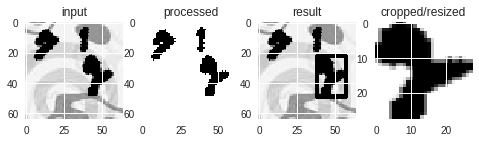

id: 9477 expected: 8


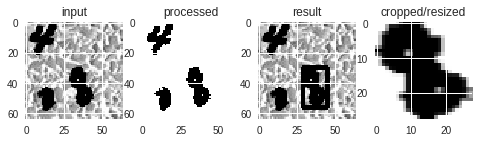

id: 4602 expected: 2


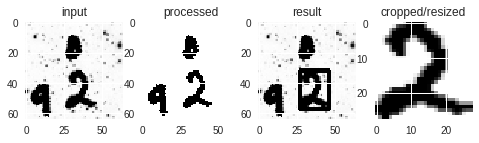

id: 13253 expected: 8


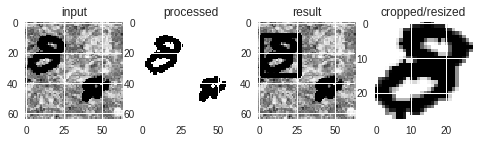

id: 23826 expected: 6


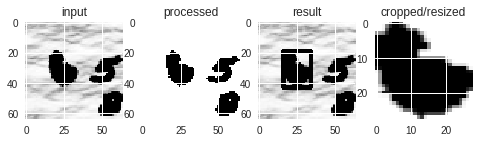

In [0]:
#visualize results
plt.rcParams['figure.figsize'] = [15, 5]
random = np.random.randint(0, len(X_data), size=(5,))
for i in random:
    print('id:', i, 'expected:', y_data_orig['Category'].iloc[i])
    find_best_bound_region(X_data[i], display=True)

In [0]:
def pre_process_images(X_data):
    X_data_processed = []
    
    for i in range(len(X_data)):
        X_data_processed.append(find_best_bound_region(X_data[i]))
    
    return np.array(X_data_processed)/255.0

In [0]:
X_data_processed = pre_process_images(X_data)

In [0]:
X_data_processed2 = X_data_processed.reshape(X_data_processed.shape[0], img_dim, img_dim, 1)
X_data_processed2.shape

(40000, 28, 28, 1)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_data_processed2, y_data, test_size=0, random_state=39)

In [0]:
X_train.shape

(40000, 28, 28, 1)

In [0]:
# Augment mnist data for training

mnist = tf.keras.datasets.mnist

(X_train_mnist, y_train_mnist),(X_test_mnist, y_test_mnist) = mnist.load_data()
X_train_mnist, X_test_mnist = X_train_mnist / 255.0, X_test_mnist / 255.0

X_data_mnist = np.append(X_train_mnist, X_test_mnist, axis=0)
X_data_mnist2 = X_data_mnist.reshape(X_data_mnist.shape[0], img_dim, img_dim, 1)

y_data_mnist = np.append(y_train_mnist, y_test_mnist, axis=0)


X_train_combined = np.append(X_train, X_data_mnist2, axis=0)
print(X_train_combined.shape)

y_train_combined = np.append(y_train, keras.utils.to_categorical(y_data_mnist), axis=0)
print(y_train_combined.shape)

11493376/11490434 [==============================] - 0s 0us/step
(110000, 28, 28, 1)
(110000, 10)


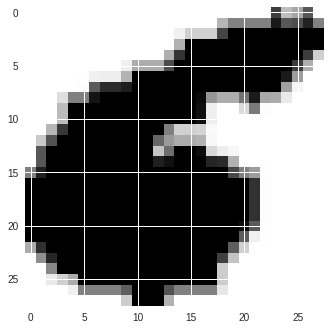

In [0]:
plt.imshow(X_train_combined[4373].reshape(img_dim, img_dim))

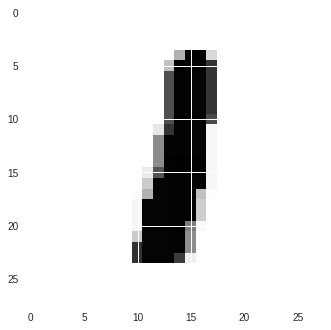

In [0]:
plt.imshow(X_train_combined[74373].reshape(img_dim, img_dim))

In [0]:
def get_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_dim,img_dim,1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    
    return model


def get_model2():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_dim,img_dim,1)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))


  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
  return model

In [0]:
data_generator = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1)


In [0]:
model = get_model2()


from keras.callbacks import ModelCheckpoint
filepath="checkpointing.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

num_steps= 1000
batch_size=1024
model.fit_generator(data_generator.flow(X_train, y_train,batch_size=batch_size),
          callbacks=callbacks_list,
          epochs=100,
          steps_per_epoch=num_steps)


#model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/100
1000/1000 [==============================] - 295s 295ms/step - loss: 0.4485 - acc: 0.8792
Epoch 2/100


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1000/1000 [==============================] - 295s 295ms/step - loss: 0.2761 - acc: 0.9315
Epoch 3/100
1000/1000 [==============================] - 284s 284ms/step - loss: 0.2405 - acc: 0.9400
Epoch 4/100
1000/1000 [==============================] - 282s 282ms/step - loss: 0.2203 - acc: 0.9450
Epoch 5/100
1000/1000 [==============================] - 280s 280ms/step - loss: 0.2042 - acc: 0.9484
Epoch 6/100
1000/1000 [==============================] - 280s 280ms/step - loss: 0.1919 - acc: 0.9515
Epoch 7/100
1000/1000 [==============================] - 279s 279ms/step - loss: 0.1821 - acc: 0.9537
Epoch 8/100
1000/1000 [==============================] - 278s 278ms/step - loss: 0.1738 - acc: 0.9554
Epoch 9/100
1000/1000 [==============================] - 281s 281ms/step - loss: 0.1652 - acc: 0.9569
Epoch 10/100
1000/1000 [==============================] - 279s 279ms/step - loss: 0.1596 - acc: 0.9583
Epoch 11/100
1000/1000 [==============================] - 276s 276ms/step - loss: 0.1547 - ac

In [0]:
model.save('epoch_100_batch_size_1024_with_interpolation_newnewbb_imagegen_with_mnist.h5')
!mv epoch_100_batch_size_1024_with_interpolation_newnewbb_imagegen_with_mnist.h5 gdrive/My\ Drive/COMP551_proj3/models/
#model.save('gdrive/My Drive/COMP551_proj3/models/epoch_100_batch_size_1024_with_interpolation_newnewbb_imagegen_with_mnist.h5')

In [0]:
#test images
X_test_processed = pre_process_images(X_test)
X_test_processed2 = X_test_processed.reshape(X_test_processed.shape[0], img_dim, img_dim, 1)
print(X_test_processed2.shape)

In [0]:
predictions = model.predict_classes(X_test_processed2)
pd.DataFrame(predictions).to_csv("epoch_100_batch_size_1024_with_interpolation_newnewbb_imagegen_with_mnist.csv", header=['Category'], index_label='Id')

#see prediction distribution
y = np.bincount(predictions)
ii = np.nonzero(y)[0]
print(ii)
print(y[ii])

In [0]:
!ls
!mv epoch_100_batch_size_1024_with_interpolation_newnewbb_imagegen_with_mnist.csv gdrive/My\ Drive/COMP551_proj3/
!ls gdrive/My\ Drive/COMP551_proj3/